<a href="https://colab.research.google.com/github/gladysadyaz/VAR/blob/main/30RELU_Hybrid_LSTM__Wisman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [45]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [46]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='FIXVAR')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -19.95         1700
2023-01-03   2.17         2052
2023-01-04  22.77         2008
2023-01-05  18.88         3759
2023-01-06  43.49         3592


In [47]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [48]:
# Select only the 'Wisman Bali' column for input and output
df_residual = df['Wisman Bali']
data2 = df_residual.copy()
data2

,Wisman Bali
Date,
2023-01-02,1700
2023-01-03,2052
2023-01-04,2008
2023-01-05,3759
2023-01-06,3592
...,...
2025-01-16,-2399
2025-01-17,-1242
2025-01-18,-1792


In [49]:
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [50]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [51]:
# Set the time step
time_step = 30

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [52]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

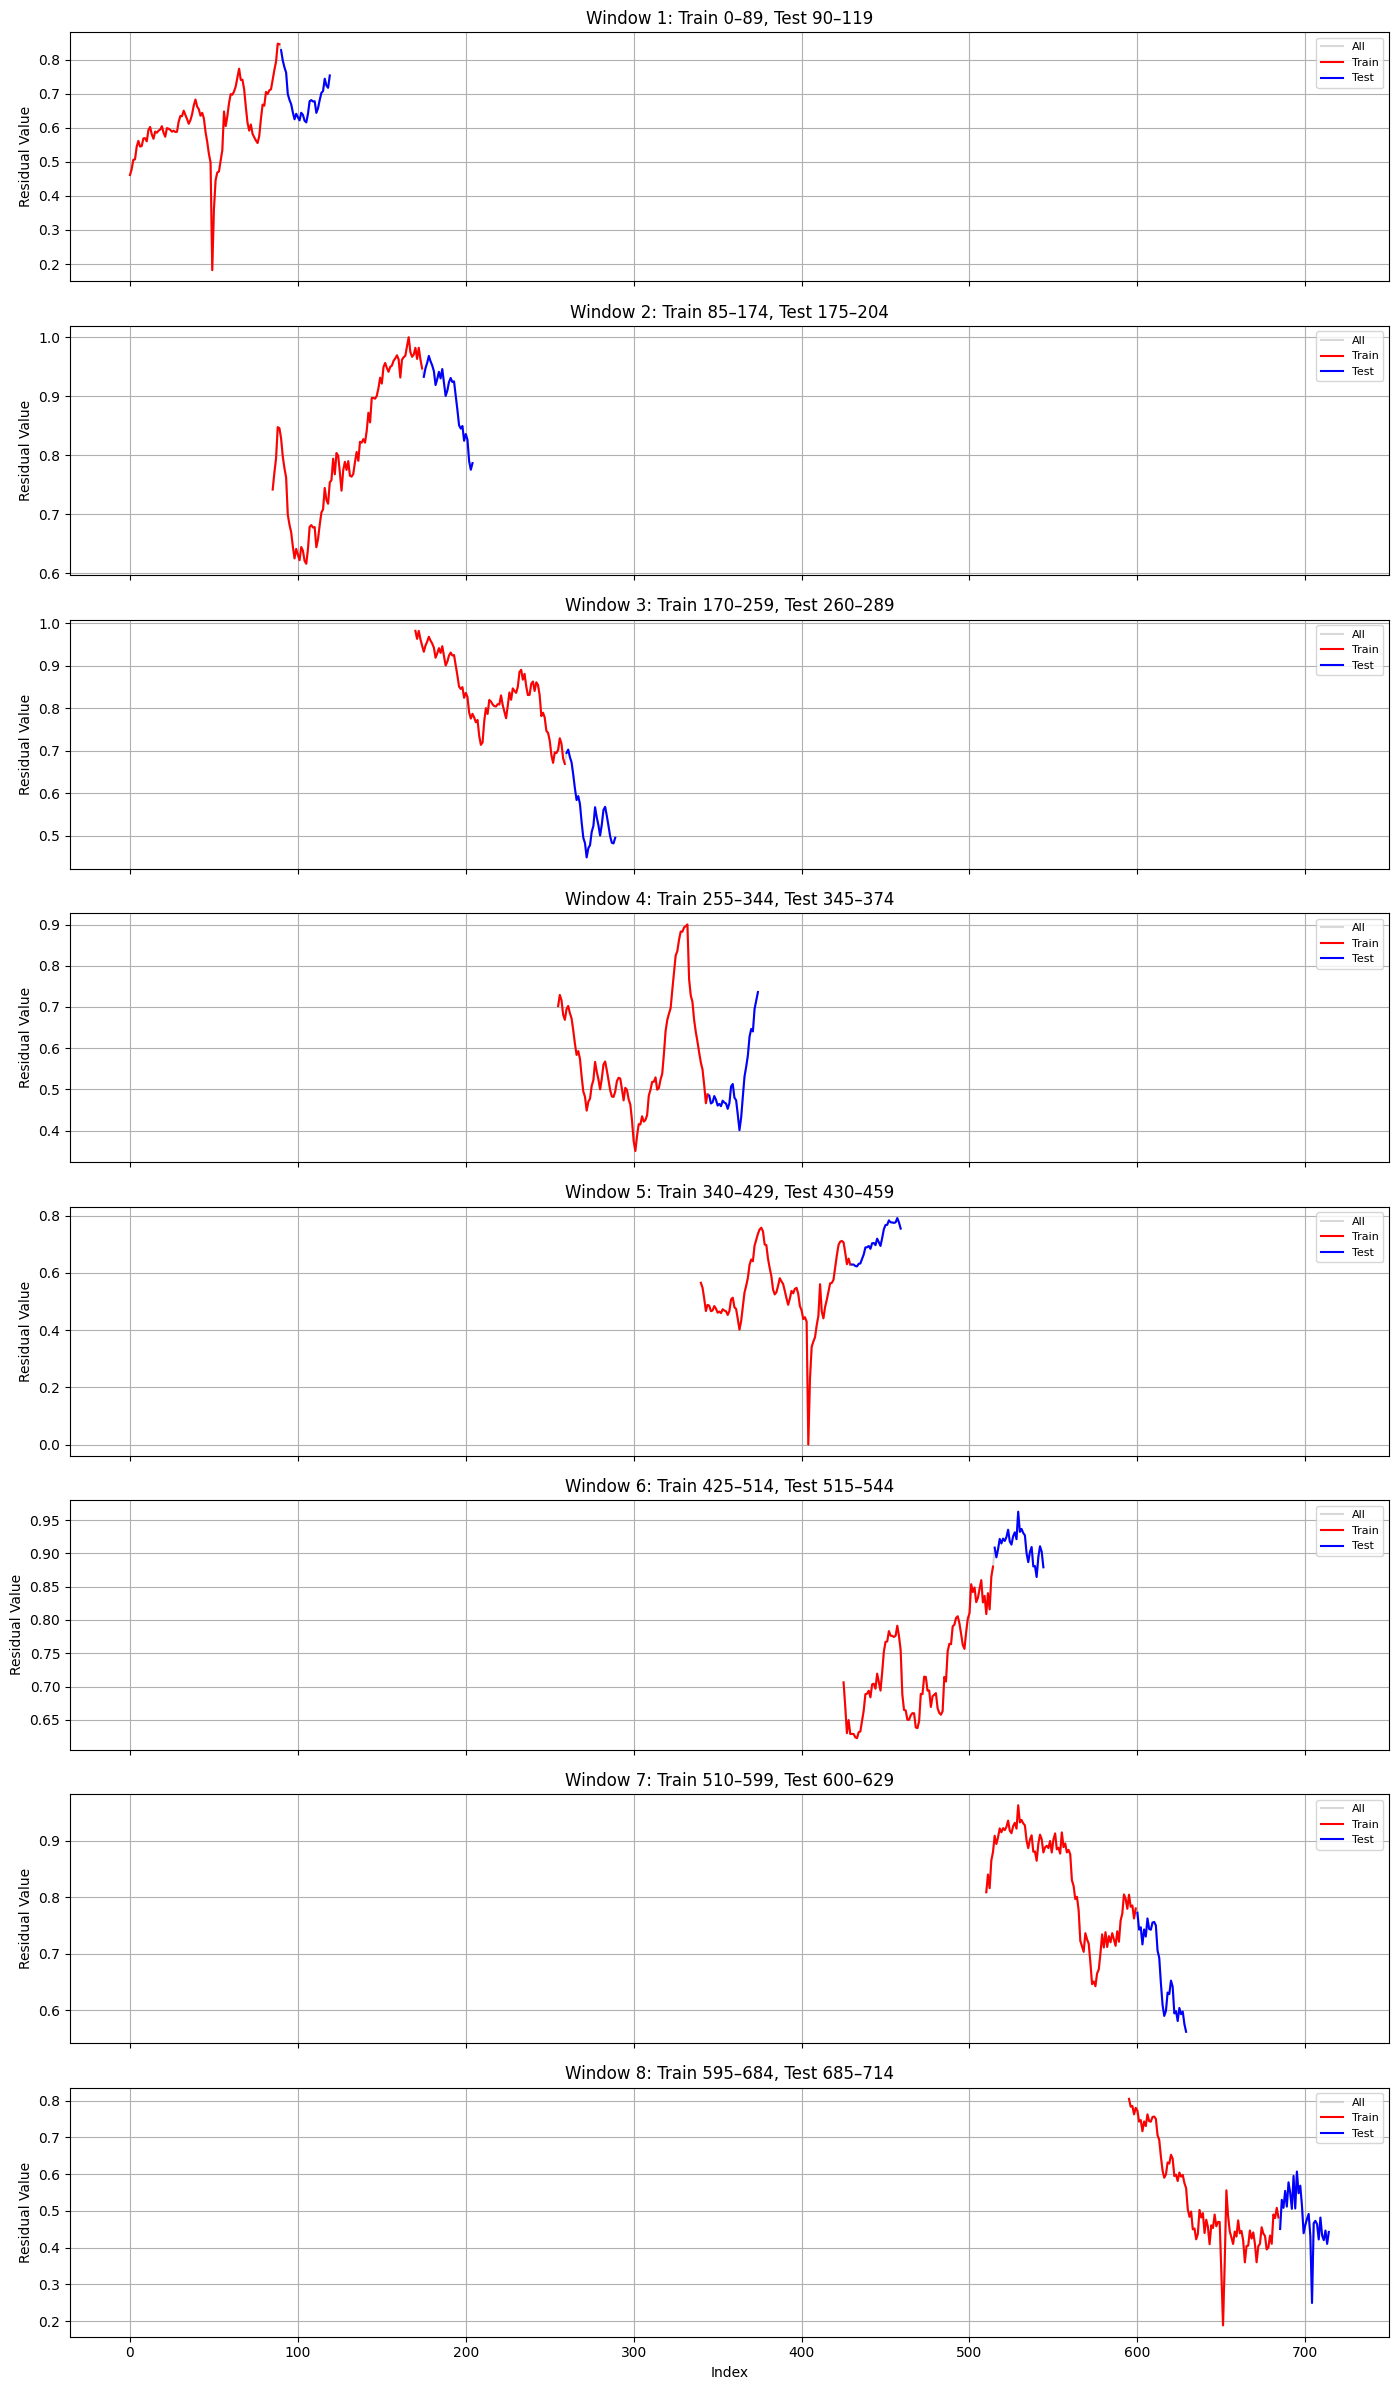

In [53]:
def plot_sliding_windows_vertical(y, train_size=90, test_size=30, shift=85, n_windows=8):
    y = y.flatten()
    total_len = len(y)

    fig, axs = plt.subplots(n_windows, 1, figsize=(14, 3 * n_windows), sharex=True)

    for i in range(n_windows):
        start_train = shift * i
        end_train = start_train + train_size
        end_test = end_train + test_size

        if end_test > total_len:
            break

        ax = axs[i]

        # Plot all data background (optional)
        ax.plot(range(start_train, end_test), y[start_train:end_test], color='gray', alpha=0.3, label='All')

        # Plot train (merah)
        ax.plot(range(start_train, end_train), y[start_train:end_train], color='red', label='Train')

        # Plot test (biru)
        ax.plot(range(end_train, end_test), y[end_train:end_test], color='blue', label='Test')

        ax.set_title(f'Window {i+1}: Train {start_train}–{end_train-1}, Test {end_train}–{end_test-1}')
        ax.set_ylabel('Residual Value')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True)

    plt.xlabel('Index')
    plt.tight_layout()
    plt.show()

# Versi vertikal dengan shift 89
plot_sliding_windows_vertical(y2, train_size=90, test_size=30, shift=85, n_windows=8)


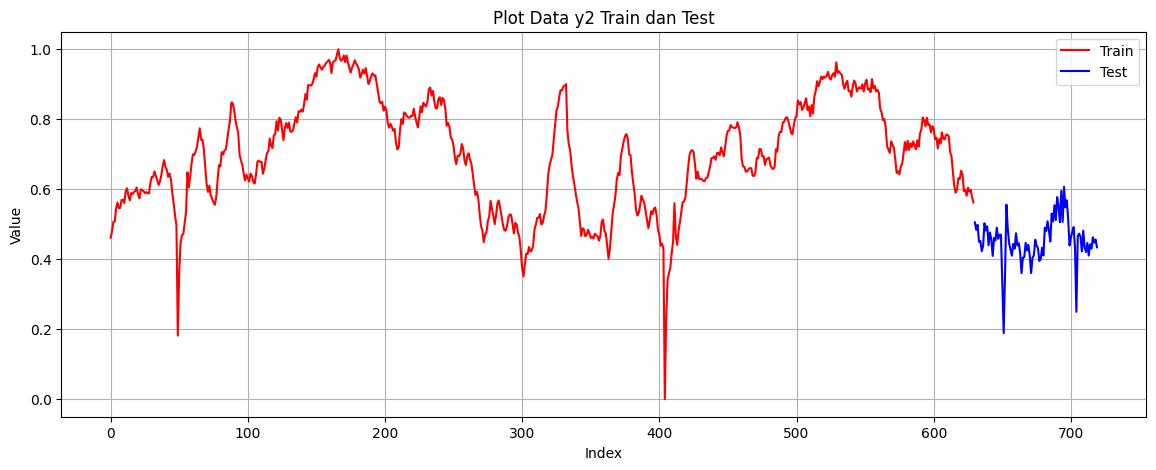

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Plot y2 train (merah)
plt.plot(range(len(y2_train)), y2_train, color='red', label='Train')

# Plot y2 test (biru), mulai dari index train_size2 supaya terlihat berkelanjutan
plt.plot(range(len(y2_train), len(y2_train) + len(y2_test)), y2_test, color='blue', label='Test')

plt.title('Plot Data y2 Train dan Test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## Hypertuning Parameters

In [55]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='relu', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [56]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50,100],
    'units2': [50,100],
    'dropout_rate': [0,0.2,0.3],
    'learning_rate': [0.01,0.001],
    'batch_size': [16,32],
    'epochs': [100],
    'init_scheme': ['he_uniform', 'glorot_uniform']
}

In [57]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [58]:
# Initialize variables to track the best model and the best score for LSTM2
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Perform manual grid search for LSTM
for params in param_list_lstm2:
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    print(f"Training LSTM model with parameters: units1={units1}, units2={units2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

    model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_lstm2 = model_lstm2.fit(X2_train, y2_train, batch_size=batch_size, epochs=epochs, validation_data=(X2_test, y2_test), callbacks=[early_stopping], verbose=0)

    val_loss = min(history_lstm2.history['val_loss'])

    if val_loss < best_score_lstm2:
        best_score_lstm2 = val_loss
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

print(f"Best LSTM score: {best_score_lstm2} with parameters: {best_params_lstm2}")

Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=32, epochs=100
Training LSTM model with par

## Model

In [59]:
best_params_lstm2

{'units1': 100,
 'units2': 50,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'batch_size': 16,
 'epochs': 100,
 'init_scheme': 'he_uniform'}

In [60]:
# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.5660 - val_loss: 0.0086
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0377 - val_loss: 0.0181
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0178 - val_loss: 0.0076
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0178 - val_loss: 0.0049
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0112 - val_loss: 0.0032
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0126 - val_loss: 0.0047
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0111 - val_loss: 0.0060
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0098 - val_loss: 0.0028
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0091 - val_loss: 0.0035
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0075 - val_loss: 0.0034
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

In [61]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_322 (LSTM)                 │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_322 (Dropout)           │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_323 (LSTM)                 │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_323 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

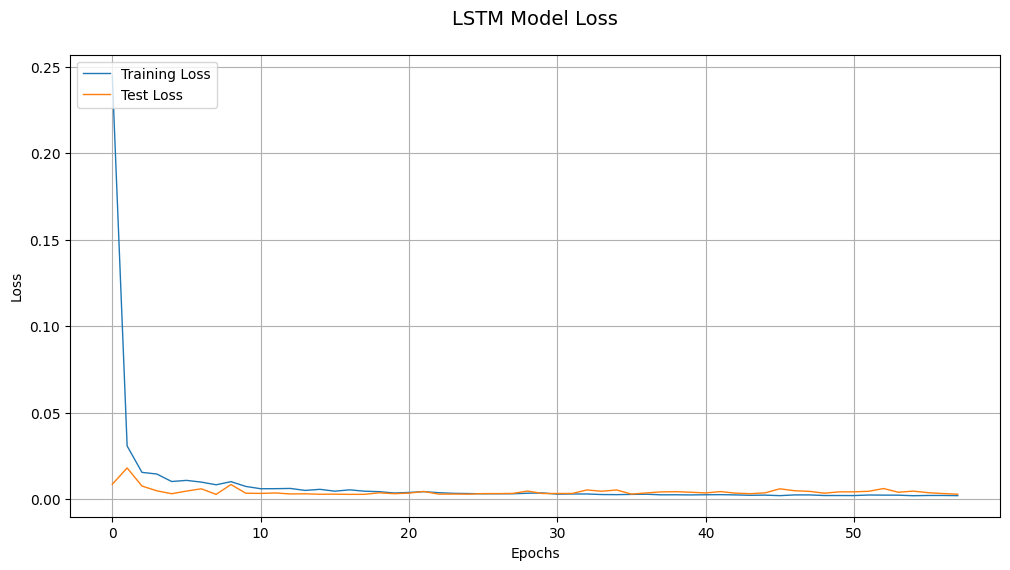

In [62]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Test Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [63]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [64]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [65]:
# Calculate MAPE for LSTM
train_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_train, train_predict_lstm2)
test_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_test, test_predict_lstm2)

print(f'Training MAPE (Wisman Bali) LSTM: {train_mape_kurs_lstm2:.4f}')
print(f'Testing MAPE (Wisman Bali) LSTM: {test_mape_kurs_lstm2:.4f}')


Training MAPE (Wisman Bali) LSTM: 0.6100
Testing MAPE (Wisman Bali) LSTM: 1.2079


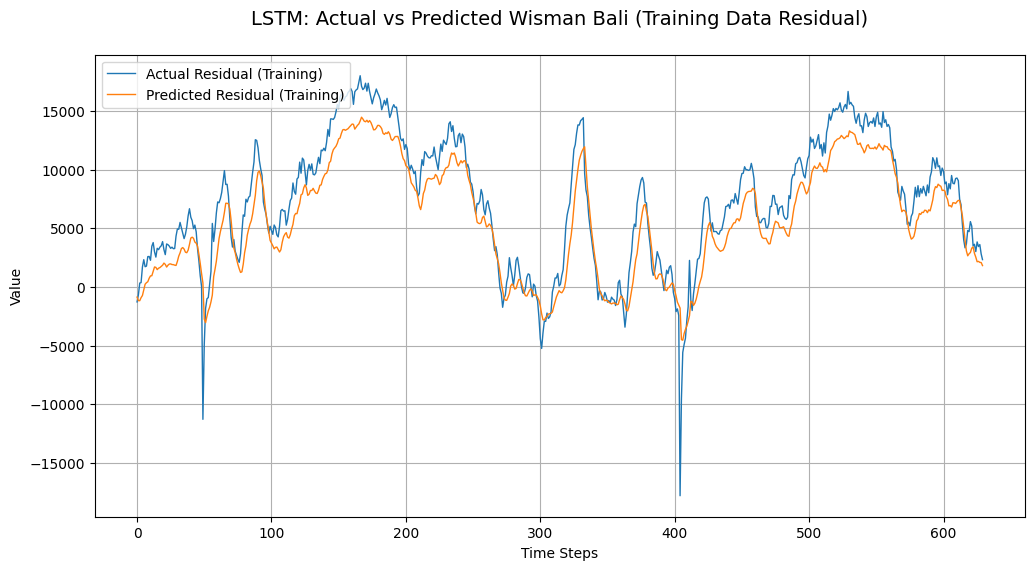

In [66]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

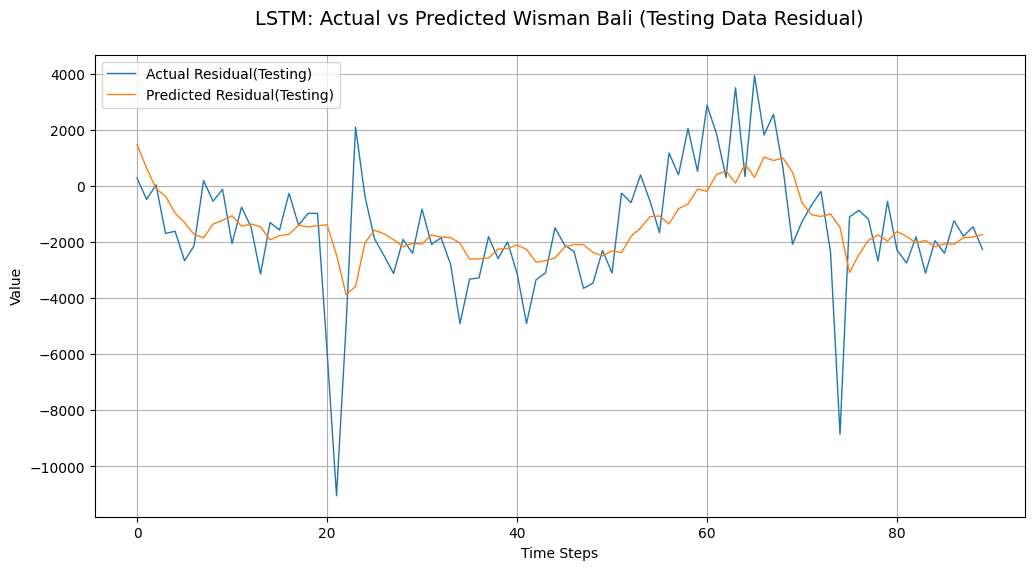

In [67]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting



In [68]:
# Forecasting for the next 90 steps
predictions_lstm2 = []

# Ambil 7 data terakhir (time_step = 7), reshape ke bentuk [1, 7, 1]
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(90):
    pred = model_manual_lstm2.predict(input_data_lstm2, verbose=0)

    # Simpan hasil prediksi (scalar)
    predictions_lstm2.append(pred[0][0])

    # Update input dengan menambahkan prediksi dan membuang data paling awal
    input_data_lstm2 = np.concatenate((input_data_lstm2[:, 1:, :], [[[pred[0][0]]]]), axis=1)

# Ubah ke array dan reshape untuk inverse transform
predictions_lstm2 = np.array(predictions_lstm2).reshape(-1, 1)

# Inverse transform ke skala asli
predictions_lstm2_actual = scaler2.inverse_transform(predictions_lstm2)

# Simpan hasil ke DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2_actual, columns=['Predicted Residual Wisman Bali'])

# Sesuaikan index
df_future_predictions_lstm2.index = df_update.index

# Tampilkan hasil
df_future_predictions_lstm2


,Predicted Residual Wisman Bali
Date,
2024-10-23,-1870.280029
2024-10-24,-1864.917969
2024-10-25,-1853.820435
2024-10-26,-1847.114136
2024-10-27,-1841.417114
...,...
2025-01-16,-1818.261963
2025-01-17,-1818.261963
2025-01-18,-1818.261963


In [69]:
# Forecasting for the next 90 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(90):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [70]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
df_future_predictions_lstm2.index = df_update.index

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
Date,
2024-10-23,-1870.280010
2024-10-24,-1864.917954
2024-10-25,-1853.820439
2024-10-26,-1847.114135
2024-10-27,-1841.417084
...,...
2025-01-16,-1818.261878
2025-01-17,-1818.261878
2025-01-18,-1818.261878


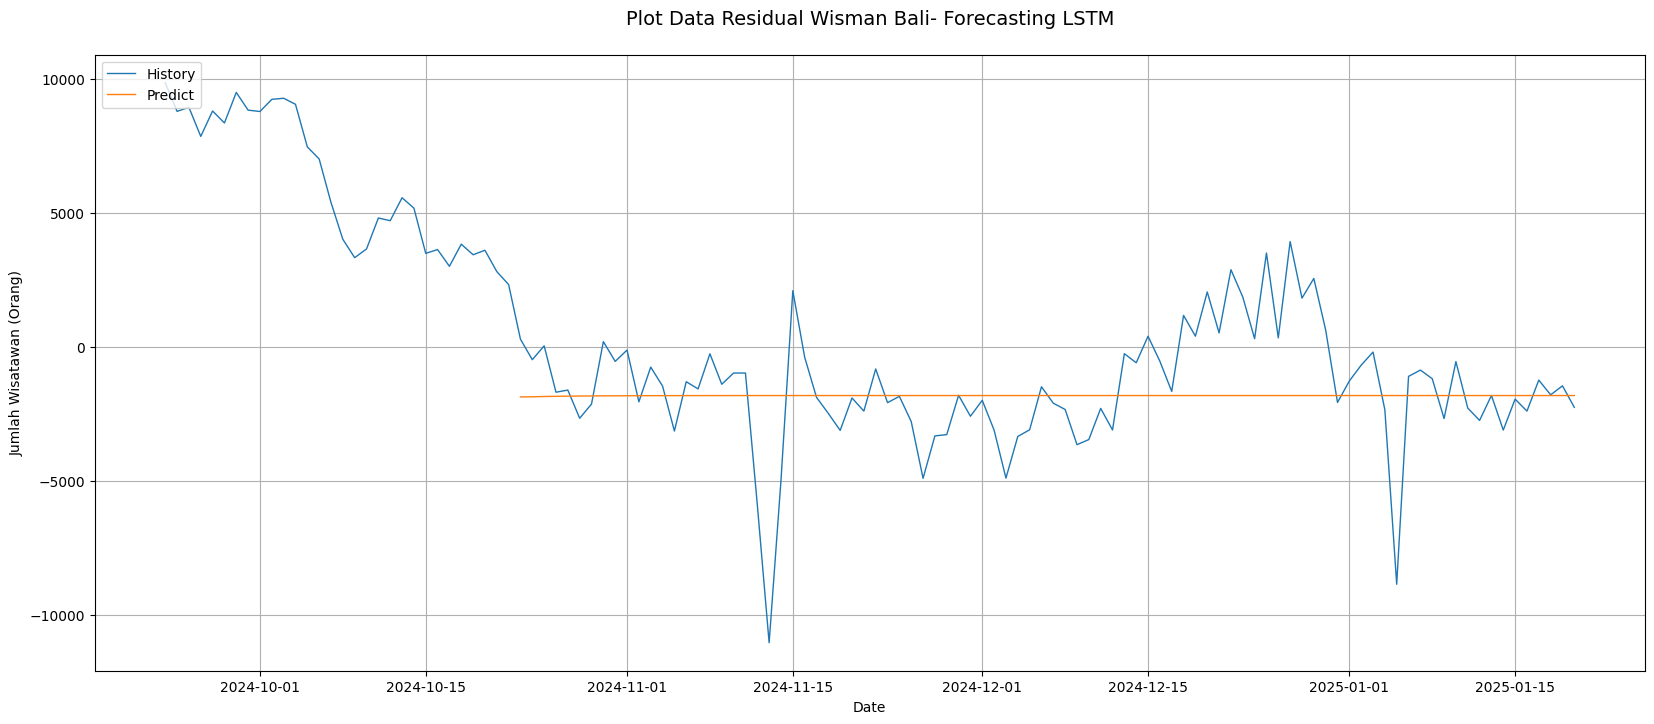

In [71]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-120:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (Orang)')
plt.title('Plot Data Residual Wisman Bali- Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VARXLSTM

## Model

In [72]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

                Kurs  Wisman Bali
Date                             
2024-10-23  15563.19        19031
2024-10-24  15556.90        19251
2024-10-25  15558.64        20218
2024-10-26  15557.91        19982
2024-10-27  15553.73        20022


In [73]:
df_linear = df_forecast[['Wisman Bali']]
df_linear

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-02-15,20767
2025-02-16,20778
2025-02-17,20790


In [74]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Wisman Bali
Date,
2024-10-23,-1870.280010
2024-10-24,-1864.917954
2024-10-25,-1853.820439
2024-10-26,-1847.114135
2024-10-27,-1841.417084
...,...
2025-01-16,-1818.261878
2025-01-17,-1818.261878
2025-01-18,-1818.261878


In [75]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear['Wisman Bali'] + df_nonlinear['Predicted Residual Wisman Bali'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,17160.719990
2024-10-24,17386.082046
2024-10-25,18364.179561
2024-10-26,18134.885865
2024-10-27,18180.582916
...,...
2025-02-15,NaN
2025-02-16,NaN
2025-02-17,NaN


In [76]:
df_hybrid_final = pd.merge(df_update['Wisman Bali'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(90, 2)


,Wisman Bali,Hybrid Wisman Bali
Date,,
2024-10-23,19314,17160.719990
2024-10-24,18771,17386.082046
2024-10-25,20254,18364.179561
2024-10-26,18288,18134.885865
2024-10-27,18408,18180.582916
...,...,...
2025-01-16,18021,18601.738122
2025-01-17,19190,18613.738122
2025-01-18,18652,18625.738122


## Evaluation & Visualization

In [77]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Wisman Bali']
y_pred = df_hybrid_final['Hybrid Wisman Bali']

In [78]:
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # dikali 100 agar jadi persentase
print(f"Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: 9.04%


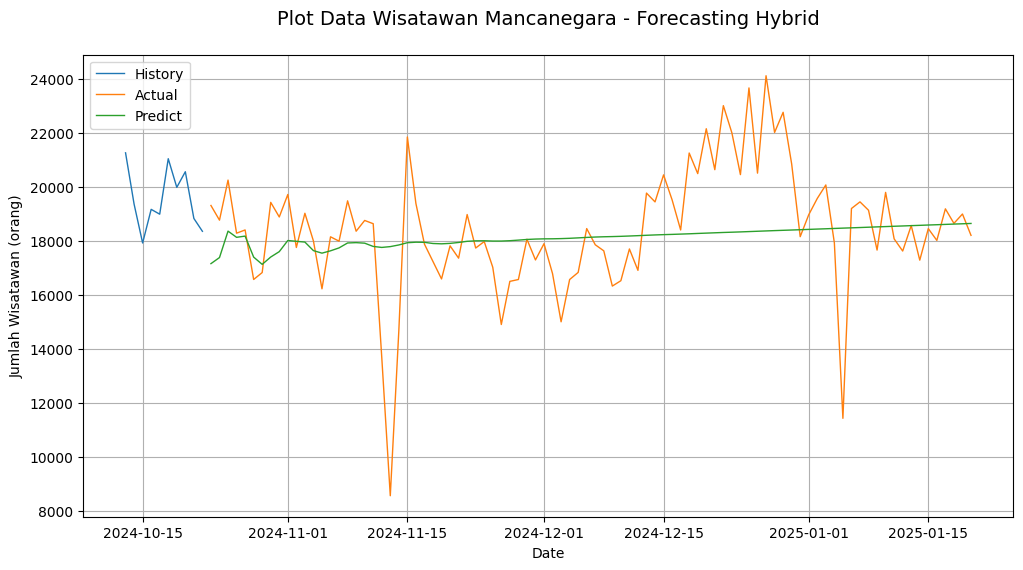

In [79]:
# Plot Data
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Wisman Bali'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (orang)')
plt.title('Plot Data Wisatawan Mancanegara - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# Forecast 30 Hari

In [80]:
# Forecasting for the next 120 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(120):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━

In [81]:
dates = pd.date_range(start="2024-10-23", periods=120, freq='D')

In [82]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

df_future_predictions_lstm2.index = dates

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
2024-10-23,-1870.280010
2024-10-24,-1864.917954
2024-10-25,-1853.820439
2024-10-26,-1847.114135
2024-10-27,-1841.417084
...,...
2025-02-15,-1818.261878
2025-02-16,-1818.261878
2025-02-17,-1818.261878
2025-02-18,-1818.261878


In [83]:
df_linear = df_forecast[['Wisman Bali']]
df_linear

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-02-15,20767
2025-02-16,20778
2025-02-17,20790


In [84]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Wisman Bali
2024-10-23,-1870.280010
2024-10-24,-1864.917954
2024-10-25,-1853.820439
2024-10-26,-1847.114135
2024-10-27,-1841.417084
...,...
2025-02-15,-1818.261878
2025-02-16,-1818.261878
2025-02-17,-1818.261878
2025-02-18,-1818.261878


In [85]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear['Wisman Bali'] + df_nonlinear['Predicted Residual Wisman Bali'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,17160.719990
2024-10-24,17386.082046
2024-10-25,18364.179561
2024-10-26,18134.885865
2024-10-27,18180.582916
...,...
2025-02-15,18948.738122
2025-02-16,18959.738122
2025-02-17,18971.738122


In [86]:
df_forecast30 = df_hybrid.iloc[-30:]

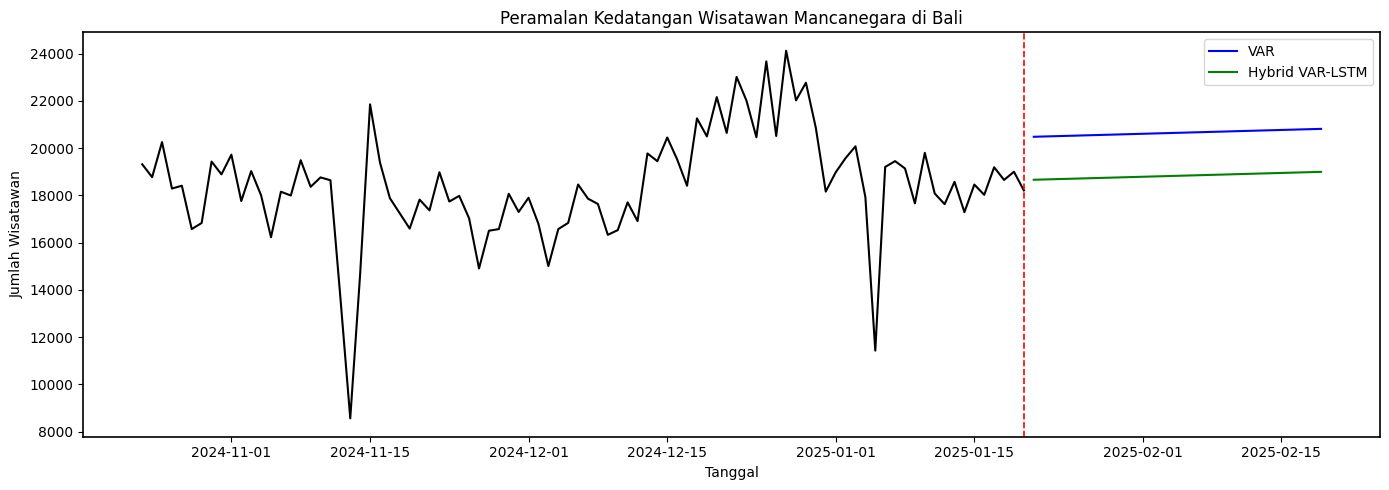

In [87]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.style.use('default')


fig, ax = plt.subplots(figsize=(14,5))  # buat figure dan axes secara eksplisit

# plot di axes yang sudah dibuat
ax.plot(df_update.index, df_update['Wisman Bali'],  color='black', linewidth=1.5)
ax.plot(df_linear.index[-30:], df_linear[-30:], label='VAR', color='blue', linewidth=1.5)
ax.plot(df_forecast30.index, df_forecast30, label='Hybrid VAR-LSTM', color='green', linewidth=1.5)

cutoff_date = df_update.index[-1]
ax.axvline(x=cutoff_date, color='red', linestyle='--', linewidth=1.2)

# hilangkan grid dalam (kotak bantu)
ax.grid(False)

# pastikan semua spines aktif dan terlihat
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.2)

# label dan judul
ax.set_title('Peramalan Kedatangan Wisatawan Mancanegara di Bali')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Jumlah Wisatawan')
ax.legend()

plt.tight_layout()
plt.show()


#Cross Validation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np

# Inisialisasi variabel untuk tracking model terbaik
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Ukuran train-test dan shifting antar window
train_sz = 90
test_sz = 30
shift = 85

# Loop untuk grid search dengan parameter dari param_list_lstm2
for params in tqdm(param_list_lstm2):
    val_mape_scores = []
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    for i in range(8):
        idx_train = train_sz + shift * i
        idx_test = train_sz + test_sz + shift * i

        # Split data
        X2_train, X2_test = X2[:idx_train], X2[idx_train:idx_test]
        y2_train, y2_test = y2[:idx_train], y2[idx_train:idx_test]

        # Buat model LSTM2 dengan parameter saat ini
        model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

        # Callback early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Training
        model_lstm2.fit(
            X2_train, y2_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X2_test, y2_test),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan inverse transform
        y2_test_pred = model_lstm2.predict(X2_test)
        y2_test_pred_denorm = scaler2.inverse_transform(y2_test_pred).flatten()
        y2_test_denorm = scaler2.inverse_transform(y2_test.reshape(-1, 1)).flatten()

        # Hitung MAPE
        mape_score = mean_absolute_percentage_error(y2_test_denorm, y2_test_pred_denorm)
        val_mape_scores.append(mape_score)

        # Opsional: lihat MAPE per window
        print(f"MAPE window {i+1}: {mape_score:.4f}")

    # Hitung rata-rata MAPE dari 8 window
    mape_avg = np.mean(val_mape_scores)

    # Simpan jika ini model terbaik sejauh ini
    if mape_avg < best_score_lstm2:
        best_score_lstm2 = mape_avg
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

# Print hasil akhir
print(f"Best LSTM2 average MAPE: {best_score_lstm2:.4f}")
print(f"Best parameters: {best_params_lstm2}")

  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAPE window 1: 0.2206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
MAPE window 2: 0.1238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 3: 3.5729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
MAPE window 4: 0.7043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 5: 0.1111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 6: 0.0496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 7: 0.1988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


  2%|▏         | 1/64 [01:45<1:50:47, 105.52s/it]

MAPE window 8: 1.1450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 1: 0.1861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 2: 0.0561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 3: 3.7051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 4: 0.9165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 5: 0.0865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 6: 0.0343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 7: 0.2022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


  3%|▎         | 2/64 [03:32<1:49:45, 106.22s/it]

MAPE window 8: 1.0488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 1: 2.8004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
MAPE window 2: 0.1311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 3: 21.5635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 4: 3.9234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 5: 0.0868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 6: 0.0842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
MAPE window 7: 0.2263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


  5%|▍         | 3/64 [04:42<1:31:23, 89.89s/it] 

MAPE window 8: 1.2111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 1: 0.1899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
MAPE window 2: 0.0911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
MAPE window 3: 5.0614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
MAPE window 4: 0.8890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
MAPE window 5: 0.0650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 6: 0.1292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
MAPE window 7: 0.1873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  6%|▋         | 4/64 [06:14<1:30:30, 90.51s/it]

MAPE window 8: 1.2956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 1: 0.2424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 2: 0.0987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
MAPE window 3: 5.2251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 4: 1.3444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
MAPE window 5: 0.1409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 6: 0.0467
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MAPE window 7: 0.3315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


  8%|▊         | 5/64 [07:52<1:31:45, 93.32s/it]

MAPE window 8: 1.6013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 1: 0.3004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
MAPE window 2: 0.0762
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 3: 2.8050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
MAPE window 4: 1.3096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MAPE window 5: 0.1653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 6: 0.0789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 7: 0.2461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


  9%|▉         | 6/64 [09:51<1:38:43, 102.13s/it]

MAPE window 8: 1.1294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
MAPE window 1: 0.2842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 2: 0.1032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
MAPE window 3: 4.0349
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 4: 1.2474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 5: 0.1179
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 6: 0.0606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 7: 0.3627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 11%|█         | 7/64 [11:03<1:27:35, 92.20s/it] 

MAPE window 8: 1.3852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 1: 0.2986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
MAPE window 2: 0.0760
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 3: 2.6201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MAPE window 4: 1.1038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 5: 0.1803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 6: 0.0811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 7: 0.4518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 12%|█▎        | 8/64 [12:37<1:26:32, 92.73s/it]

MAPE window 8: 1.1766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
MAPE window 1: 0.2193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 2: 0.1321
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAPE window 3: 5.3676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 4: 1.0291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 5: 0.0781
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
MAPE window 6: 0.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 7: 0.1702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 14%|█▍        | 9/64 [14:05<1:23:43, 91.34s/it]

MAPE window 8: 0.8244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 1: 0.2506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 2: 0.0565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 3: 4.4421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 4: 0.8851
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 5: 0.0943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
MAPE window 6: 0.0856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 7: 0.2006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 16%|█▌        | 10/64 [15:43<1:23:54, 93.23s/it]

MAPE window 8: 1.3950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
MAPE window 1: 0.4174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 2: 0.1231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 3: 18.7058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 4: 4.1599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 5: 0.0793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 6: 0.2608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 7: 0.1650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 17%|█▋        | 11/64 [16:49<1:15:14, 85.17s/it]

MAPE window 8: 0.9346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 1: 0.2127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 2: 0.0974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 3: 4.7717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 4: 0.9336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAPE window 5: 0.1432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
MAPE window 6: 0.1289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
MAPE window 7: 0.2266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 19%|█▉        | 12/64 [18:02<1:10:33, 81.41s/it]

MAPE window 8: 1.1613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 1: 0.2429
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
MAPE window 2: 0.1192
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 3: 6.6773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 4: 1.6194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 5: 0.1242
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
MAPE window 6: 0.0458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
MAPE window 7: 0.6796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 20%|██        | 13/64 [19:49<1:15:45, 89.12s/it]

MAPE window 8: 1.0807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 1: 0.2909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
MAPE window 2: 0.0795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
MAPE window 3: 2.4130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
MAPE window 4: 1.3576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
MAPE window 5: 0.1541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 6: 0.0827
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MAPE window 7: 0.2341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 22%|██▏       | 14/64 [21:37<1:19:02, 94.85s/it]

MAPE window 8: 1.1623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
MAPE window 1: 0.3122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 2: 0.1193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 3: 6.2201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
MAPE window 4: 1.8373
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 5: 0.1744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
MAPE window 6: 0.0534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 7: 0.7832
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 23%|██▎       | 15/64 [22:54<1:12:59, 89.37s/it]

MAPE window 8: 2.3193
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 1: 0.3080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
MAPE window 2: 0.0769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
MAPE window 3: 3.3588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
MAPE window 4: 1.4281
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
MAPE window 5: 0.1698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
MAPE window 6: 0.0908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 7: 0.4499
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


 25%|██▌       | 16/64 [24:15<1:09:32, 86.93s/it]

MAPE window 8: 1.4088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 3: 55.0344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 7: 4.5230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 27%|██▋       | 17/64 [25:27<1:04:27, 82.29s/it]

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 1: 0.2124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
MAPE window 2: 0.0638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
MAPE window 3: 8.1064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 4: 0.8159
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 5: 0.0760
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
MAPE window 6: 0.0334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MAPE window 7: 0.1849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


 28%|██▊       | 18/64 [27:33<1:13:13, 95.52s/it]

MAPE window 8: 1.2071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 1: 3.8282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
MAPE window 3: 55.0344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 7: 4.5230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 30%|██▉       | 19/64 [28:35<1:04:00, 85.35s/it]

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
MAPE window 1: 0.2366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 2: 0.1170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
MAPE window 3: 4.1552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
MAPE window 4: 2.3798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 5: 0.1670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 6: 0.0433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 7: 0.1978
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 31%|███▏      | 20/64 [30:06<1:03:52, 87.10s/it]

MAPE window 8: 1.2825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
MAPE window 1: 0.2348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 2: 0.1038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MAPE window 3: 9.9204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 4: 1.1596
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 5: 0.2415
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
MAPE window 6: 0.0543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 7: 0.1778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 33%|███▎      | 21/64 [31:46<1:05:10, 90.94s/it]

MAPE window 8: 1.3650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 1: 0.2363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 2: 0.0838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
MAPE window 3: 4.6515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 4: 1.1050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 5: 0.1585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 6: 0.1429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 7: 0.2773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


 34%|███▍      | 22/64 [34:01<1:12:57, 104.24s/it]

MAPE window 8: 1.1938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
MAPE window 1: 0.2036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 2: 0.0871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
MAPE window 3: 13.6109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
MAPE window 4: 1.2240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
MAPE window 5: 0.1090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 6: 0.0425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
MAPE window 7: 0.2066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 36%|███▌      | 23/64 [35:13<1:04:37, 94.57s/it] 

MAPE window 8: 1.7585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
MAPE window 1: 0.2830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 2: 0.0802
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 3: 4.1249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 4: 2.0287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
MAPE window 5: 0.1744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
MAPE window 6: 0.0891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 7: 0.3259
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 38%|███▊      | 24/64 [36:28<59:12, 88.81s/it]  

MAPE window 8: 1.2847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
MAPE window 2: 0.2386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 3: 9.1883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 4: 1.1991
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 7: 0.1704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 39%|███▉      | 25/64 [37:40<54:17, 83.54s/it]

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 1: 0.1993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
MAPE window 2: 0.0632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
MAPE window 3: 5.4186
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
MAPE window 4: 0.8925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
MAPE window 5: 0.1716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
MAPE window 6: 0.0338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
MAPE window 7: 0.1818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 41%|████      | 26/64 [40:11<1:05:48, 103.91s/it]

MAPE window 8: 1.3712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
MAPE window 3: 55.0344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
MAPE window 7: 4.5230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 42%|████▏     | 27/64 [41:16<56:51, 92.21s/it]   

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
MAPE window 1: 0.2476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 2: 0.0582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 3: 14.1923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
MAPE window 4: 2.1063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
MAPE window 5: 0.0865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 6: 0.0575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 7: 0.2257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 44%|████▍     | 28/64 [42:48<55:19, 92.21s/it]

MAPE window 8: 1.1150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
MAPE window 1: 0.2256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 2: 0.1011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 3: 3.3884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 4: 0.8820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MAPE window 5: 0.1058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 6: 0.0382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 7: 0.3242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 45%|████▌     | 29/64 [44:48<58:32, 100.37s/it]

MAPE window 8: 1.3703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
MAPE window 1: 0.2865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 2: 0.0908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
MAPE window 3: 5.0508
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
MAPE window 4: 1.0860
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
MAPE window 5: 0.1460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
MAPE window 6: 0.1247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 7: 0.2898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


 47%|████▋     | 30/64 [46:57<1:01:51, 109.17s/it]

MAPE window 8: 1.1382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
MAPE window 1: 0.2152
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 2: 0.0737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
MAPE window 3: 8.7333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 4: 1.9911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MAPE window 5: 0.1703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 6: 0.0412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
MAPE window 7: 0.2170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


 48%|████▊     | 31/64 [48:25<56:27, 102.66s/it]  

MAPE window 8: 1.6446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
MAPE window 1: 0.6858
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
MAPE window 2: 0.0736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
MAPE window 3: 4.4633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
MAPE window 4: 1.4169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
MAPE window 5: 0.1599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
MAPE window 6: 0.1027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 7: 0.3481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 50%|█████     | 32/64 [49:55<52:48, 99.01s/it] 

MAPE window 8: 1.2428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 1: 0.3006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 2: 0.2879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 3: 3.5029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 4: 1.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
MAPE window 5: 0.0806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 6: 0.0473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
MAPE window 7: 0.1632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 52%|█████▏    | 33/64 [51:52<53:50, 104.20s/it]

MAPE window 8: 1.0123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 1: 0.2124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
MAPE window 2: 0.2480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 3: 5.0808
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
MAPE window 4: 0.8792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 5: 0.1044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 6: 0.0634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 7: 0.2115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 53%|█████▎    | 34/64 [54:16<58:11, 116.39s/it]

MAPE window 8: 1.2803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAPE window 3: 11.6218
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 6: 0.0784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 7: 0.1675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 55%|█████▍    | 35/64 [55:36<50:58, 105.45s/it]

MAPE window 8: 1.0022
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
MAPE window 1: 0.2490
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
MAPE window 2: 0.1081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
MAPE window 3: 8.9087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
MAPE window 4: 1.4027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 5: 0.1475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
MAPE window 6: 0.1427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
MAPE window 7: 0.2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 56%|█████▋    | 36/64 [56:50<44:45, 95.92s/it] 

MAPE window 8: 1.1414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
MAPE window 1: 0.2703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 2: 0.0617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
MAPE window 3: 8.4655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
MAPE window 4: 0.9071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 5: 0.0879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 6: 0.0397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
MAPE window 7: 0.2103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 58%|█████▊    | 37/64 [58:40<45:02, 100.09s/it]

MAPE window 8: 1.1477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 1: 0.2972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
MAPE window 2: 0.1161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 3: 2.7154
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
MAPE window 4: 1.1892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
MAPE window 5: 0.1401
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
MAPE window 6: 0.1190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
MAPE window 7: 0.3495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 59%|█████▉    | 38/64 [1:01:11<49:57, 115.30s/it]

MAPE window 8: 1.1185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
MAPE window 1: 0.1857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
MAPE window 2: 0.0833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
MAPE window 3: 4.7570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 4: 1.4113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
MAPE window 5: 0.0995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 6: 0.0516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
MAPE window 7: 0.2416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 61%|██████    | 39/64 [1:02:39<44:41, 107.25s/it]

MAPE window 8: 1.3137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 1: 0.3967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 2: 0.0805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 3: 3.1826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 4: 1.1971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
MAPE window 5: 0.1647
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
MAPE window 6: 0.1877
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 7: 0.3492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 62%|██████▎   | 40/64 [1:04:40<44:34, 111.45s/it]

MAPE window 8: 1.1972
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 1: 0.2451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
MAPE window 2: 0.2461
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
MAPE window 3: 3.7949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
MAPE window 4: 1.0105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
MAPE window 5: 0.0821
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
MAPE window 6: 0.0789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 7: 0.1575
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


 64%|██████▍   | 41/64 [1:07:04<46:29, 121.26s/it]

MAPE window 8: 1.1647
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
MAPE window 1: 0.2508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 2: 0.0769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 3: 3.2867
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
MAPE window 4: 0.9841
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
MAPE window 5: 0.1244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
MAPE window 6: 0.0381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
MAPE window 7: 0.1583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 66%|██████▌   | 42/64 [1:09:31<47:15, 128.90s/it]

MAPE window 8: 1.0797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
MAPE window 2: 0.2498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
MAPE window 3: 7.7072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
MAPE window 4: 2.5874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 5: 0.0943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 6: 0.0951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
MAPE window 7: 0.1714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 67%|██████▋   | 43/64 [1:10:52<40:01, 114.37s/it]

MAPE window 8: 0.9570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
MAPE window 1: 0.3682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 2: 0.1220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 3: 9.1707
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
MAPE window 4: 1.0488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 5: 0.1211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 6: 0.1573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
MAPE window 7: 0.2451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 69%|██████▉   | 44/64 [1:12:26<36:04, 108.24s/it]

MAPE window 8: 1.1470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 1: 0.2269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
MAPE window 2: 0.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
MAPE window 3: 2.5357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
MAPE window 4: 1.5360
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
MAPE window 5: 0.0885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 6: 0.0488
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
MAPE window 7: 0.2595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 70%|███████   | 45/64 [1:14:05<33:27, 105.67s/it]

MAPE window 8: 1.1524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
MAPE window 1: 0.2555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 2: 0.0791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 3: 2.3864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
MAPE window 4: 1.3721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
MAPE window 5: 0.1527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
MAPE window 6: 0.1250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 7: 0.1919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 72%|███████▏  | 46/64 [1:16:21<34:23, 114.66s/it]

MAPE window 8: 1.2075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
MAPE window 1: 0.2892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 2: 0.0944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
MAPE window 3: 2.2425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 4: 1.0467
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 5: 0.1058
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
MAPE window 6: 0.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MAPE window 7: 0.3909
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 73%|███████▎  | 47/64 [1:17:49<30:11, 106.58s/it]

MAPE window 8: 1.4411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 1: 0.3835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
MAPE window 2: 0.0848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 3: 4.8399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 4: 1.2415
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
MAPE window 5: 0.1405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
MAPE window 6: 0.2370
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
MAPE window 7: 0.2878
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 75%|███████▌  | 48/64 [1:19:37<28:35, 107.24s/it]

MAPE window 8: 1.1739
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
MAPE window 3: 55.0344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
MAPE window 7: 4.5230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 77%|███████▋  | 49/64 [1:20:57<24:43, 98.90s/it] 

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
MAPE window 1: 0.2099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 2: 0.0587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
MAPE window 3: 3.2343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
MAPE window 4: 1.0702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
MAPE window 5: 0.0628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 6: 0.2625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
MAPE window 7: 0.2136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 78%|███████▊  | 50/64 [1:22:55<24:25, 104.70s/it]

MAPE window 8: 1.0383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
MAPE window 1: 3.8340
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MAPE window 2: 2.2702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
MAPE window 3: 55.0344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
MAPE window 4: 16.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 5: 3.5345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
MAPE window 6: 2.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
MAPE window 7: 4.5230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 80%|███████▉  | 51/64 [1:24:02<20:15, 93.50s/it] 

MAPE window 8: 19.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
MAPE window 1: 0.2738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
MAPE window 2: 0.1535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
MAPE window 3: 5.6493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
MAPE window 4: 0.9314
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
MAPE window 5: 0.0821
